In [27]:
# %pip install torchextractor
# %pip uninstall clip -y
# %pip install git+https://github.com/openai/CLIP.git

In [1]:
import torch
from PIL import Image
import wandb
import torchmetrics
from torchvision.models import alexnet, inception_v3
import json
import os
from os.path import join as opj
from torchvision.transforms import *
import numpy as np
from scipy import signal
import tqdm
from torchsummary import summary
import torchextractor as tx
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import clip
from torchmetrics.image.fid import FrechetInceptionDistance
import pandas as pd
import matplotlib.pyplot as plt
import pickle

/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# model, preprocess = clip.load("ViT-B/32", device=device)


In [2]:
base_transform=Compose([Resize(425),ToTensor()])


def compute_pixcorr(shown_imgs, generated_imgs):
    pix_corr=[]
    for x,y in tqdm.tqdm(list(zip(shown_imgs,generated_imgs))):
        x=base_transform(x).numpy()
        y=base_transform(y).numpy()
        pc= np.abs(np.corrcoef(x.flatten(), y.flatten())[0][1])
        pix_corr.append(pc)
    return np.mean(pix_corr)


def ssim(shown_imgs,generated_imgs):
    ssim_metric=torchmetrics.StructuralSimilarityIndexMeasure()
    x_torch=[base_transform(i) for i in shown_imgs]
    y_torch=[base_transform(i) for i in generated_imgs]
    
    x_torch=torch.stack(x_torch)
    y_torch=torch.stack(y_torch)
    ssim=ssim_metric(x_torch,y_torch)
    
    return ssim

def n_way_acc(x,y,model,n=2,device="cpu",transforms=None):
    
    
    model.to(device)
    cosine=torch.nn.CosineSimilarity()
    acc=0
    
    ## transform all images
    
    x_torch=torch.stack([transforms(i) for i in x])
    y_torch=torch.stack([transforms(i) for i in y])
    
    
    with torch.no_grad():
        for i in tqdm.tqdm(range(len(x))):
            
            
            
            original_features=model(x_torch[i].unsqueeze(0).to(device)).cpu()
            generated_features=model(y_torch[i].unsqueeze(0).to(device)).cpu()

            rnd_idx=torch.randint(len(x),(1,)).item()

            random_features=model(y_torch[rnd_idx].unsqueeze(0).to(device)).cpu()

            gen_dist=cosine(original_features.reshape(len(original_features),-1),generated_features.reshape(len(generated_features),-1))
            rnd_dist=cosine(original_features.reshape(len(original_features),-1),random_features.reshape(len(random_features),-1))
            if gen_dist>=rnd_dist:
                acc+=1
    return acc/len(x)

In [3]:
def n_way_acc_clip(x,y,model,n=2,device="cpu",preprocess=None):
    
    cosine=torch.nn.CosineSimilarity()
    acc=0
    with torch.no_grad():
        for i in tqdm.tqdm(range(len(x))):
            
            orig_image = preprocess(x[i]).unsqueeze(0).to(device)
            
            gen_image = preprocess(y[i]).unsqueeze(0).to(device)
            
            rnd_idx=torch.randint(len(x),(1,)).item()
            rnd_image = preprocess(y[rnd_idx]).unsqueeze(0).to(device)
            
            
            
            original_features=model.encode_image(orig_image).cpu().double()
            generated_features=model.encode_image(gen_image).cpu().double()


            random_features=model.encode_image(rnd_image).cpu().double()


            gen_dist=cosine(original_features.reshape(len(original_features),-1),generated_features.reshape(len(generated_features),-1))
            rnd_dist=cosine(original_features.reshape(len(original_features),-1),random_features.reshape(len(random_features),-1))
            if gen_dist>=rnd_dist:
                acc+=1
    return acc/len(x)

In [4]:
def compute_metrics(shown_imgs,gen_imgs,device="cpu"):
    
    ##models
    
    alexnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
    alexnet_model.eval()


    alexnet_transforms=Compose([transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


    inception_transforms=Compose([transforms.Resize(342),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


    modules_2=list(alexnet_model.children())[0][:3]
    modules_5=list(alexnet_model.children())[0][:10]
    alexnet_model_2=torch.nn.Sequential(*modules_2)
    alexnet_model_5=torch.nn.Sequential(*modules_5)

    inception_model=inception_v3(pretrained=True)

    inception_model.fc = torch.nn.Identity()
    inception_model.eval()
    print() 
    
    clip_model, preprocess = clip.load("ViT-B/32", device=device)
    
    ##metrics
    
    pix_corr=compute_pixcorr(shown_imgs,gen_imgs)
    ssim_score=ssim(shown_imgs,gen_imgs)
    alex2=n_way_acc(shown_imgs,gen_imgs,alexnet_model_2,device=device,transforms=alexnet_transforms)
    alex5=n_way_acc(shown_imgs,gen_imgs,alexnet_model_5,device=device,transforms=alexnet_transforms)
    inception=n_way_acc(shown_imgs,gen_imgs,inception_model,device=device,transforms=inception_transforms)
    clip_acc=n_way_acc_clip(shown_imgs,gen_imgs,clip_model,device=device,preprocess=preprocess)
    
    return [pix_corr,ssim_score.item(),alex2,alex5,inception,clip_acc]
    

## Load images and convert them into PIL

In [5]:
subject="CSI1"
target_dir=f"outputs/{subject}"

generated=np.load(opj(target_dir,"generated_imgs.npy"))
stimuli=(np.load(opj(target_dir,"test_imgs.npy"))*255).astype(np.uint8)

generated=[Image.fromarray(i) for i in generated]
stimuli=[Image.fromarray(i) for i in stimuli]



In [6]:
metrics=compute_metrics(stimuli,generated,device="cuda:2")

Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0
/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent t

100%|█████████████████████████████████████████| 411/411 [00:11<00:00, 36.59it/s]
/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
100%|█████████████████████████████████████████| 411/411 [00:14<00:00, 28.93it/s]


In [8]:
names=["pix_corr","ssim_score","alex2","alex5","inception","clip_acc"]

d={}
for n,v in zip(names,metrics):
    print(f"{n}: {v}")
    d[n]=v

pix_corr: 0.17344348220297645
ssim_score: 0.23156166076660156
alex2: 0.5620437956204379
alex5: 0.732360097323601
inception: 0.5985401459854015
clip_acc: 0.7299270072992701


In [9]:
df=pd.DataFrame.from_dict([d])
df.to_csv(f"outputs/CSI1/aligned_metrics.csv")
df

,pix_corr,ssim_score,alex2,alex5,inception,clip_acc
0,0.173443,0.231562,0.562044,0.73236,0.59854,0.729927


## Show comparison images

In [11]:
generated_cross=generated
generated_in=np.load(f"/home/matteo/BOLD5000/outputs/{subject}/generated_imgs.npy")

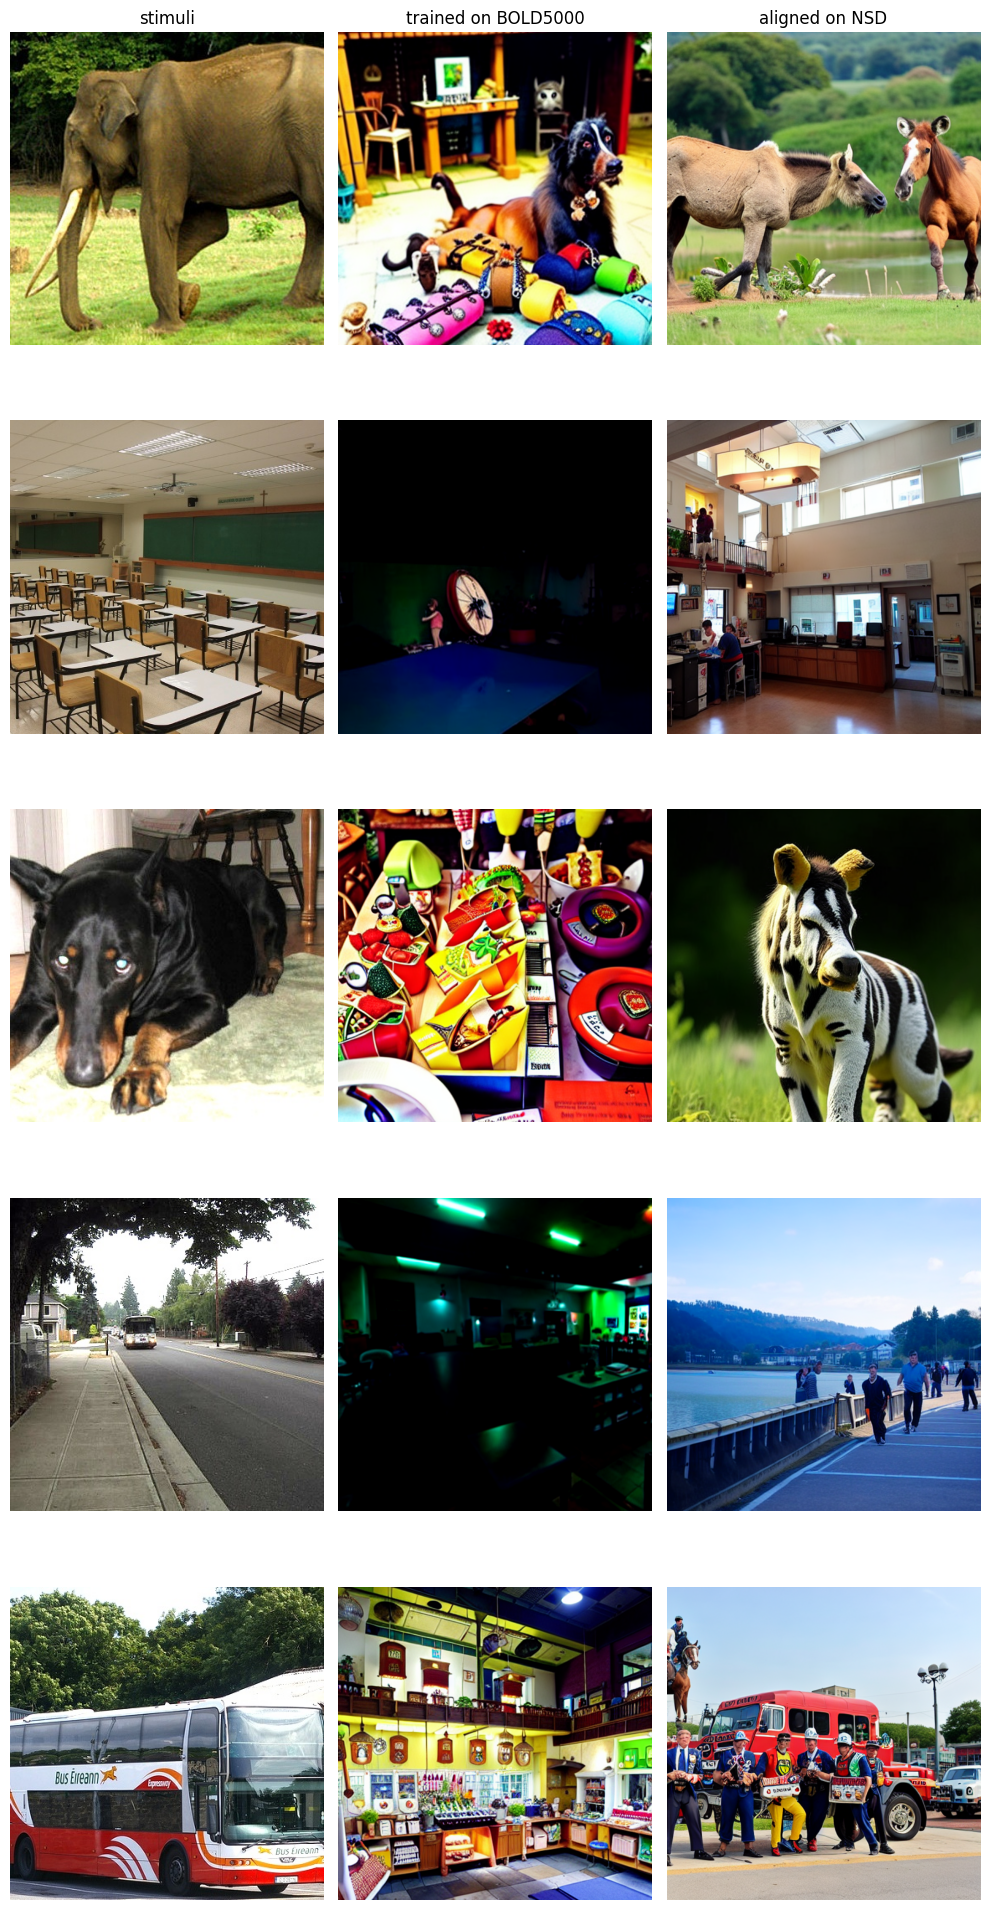

In [76]:
fig, axs=plt.subplots(5,3,figsize=(10,20))


idx = 113
column_titles = ["stimuli", "trained on BOLD5000", "aligned on NSD"]



for i in range(5):
    axs[i, 0].imshow(stimuli[idx + i])
    axs[i, 1].imshow(generated_in[idx + i])
    axs[i, 2].imshow(generated_cross[idx + i])
    for j in range(3):
        axs[i, j].axis('off')  # Turn off axes for each subplot
for j, title in enumerate(column_titles):
    axs[0, j].set_title(title)
    
plt.tight_layout()
fig.savefig(f"figures/bold_comparison_{idx}.png")
plt.show()